In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.express as px
plotly.offline.init_notebook_mode()
import cufflinks


from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

plt.style.use('ggplot')
from pandas_profiling import ProfileReport

# Incidente viales

Un enfoque de ML

## Cuantos accidentes por colonia o delegacion habra

In [3]:
df_all = pd.read_csv('../Data/incidentes-viales-c5.csv')
df_all['fecha_creacion'] = pd.to_datetime(df_all['fecha_creacion'])
df_all['fecha_cierre'] = pd.to_datetime(df_all['fecha_cierre'])

print(df_all.shape)
df_all.head()


(1397992, 18)


folio fecha_creacion hora_creacion dia_semana  \
0  GA/160123/05714     2016-01-23      22:35:04     Sábado   
1  AO/160123/05826     2016-01-23      22:50:49     Sábado   
2  C4/160124/02187     2016-01-24      09:40:11    Domingo   
3  C4/160124/05723     2016-01-24      22:40:57    Domingo   
4  C4/160124/01334     2016-01-24      04:25:15    Domingo   

                                       codigo_cierre fecha_cierre  año_cierre  \
0  (A) La unidad de atención a emergencias fue de...   2016-01-24        2016   
1  (A) La unidad de atención a emergencias fue de...   2016-01-24        2016   
2  (N) La unidad de atención a emergencias fue de...   2016-01-24        2016   
3  (N) La unidad de atención a emergencias fue de...   2016-01-24        2016   
4  (A) La unidad de atención a emergencias fue de...   2016-01-24        2016   

  mes_cierre hora_cierre    delegacion_inicio  \
0      Enero    00:21:08  VENUSTIANO CARRANZA   
1      Enero    04:40:37           CUAJIMALPA   
2      Enero    11:13:03              TLALPAN   
3      Enero    22:55:51  MAGDALENA CONTRERAS   
4      Enero    05:03:59       MIGUEL HIDALGO   

                      incidente_c4    latitud   longitud  clas_con_f_alarma  \
0  accidente-choque sin lesionados  19.422113 -99.084643         EMERGENCIA   
1  accidente-choque con lesionados  19.358320 -99.297641  URGENCIAS MEDICAS   
2  accidente-choque sin lesionados  19.217070 -99.219070         EMERGENCIA   
3  accidente-choque sin lesionados  19.320580 -99.241010         EMERGENCIA   
4  accidente-choque sin lesionados  19.452900 -99.215870         EMERGENCIA   

       tipo_entrada    delegacion_cierre                  geopoint  mes  
0  BOTÓN DE AUXILIO  VENUSTIANO CARRANZA      19.422113,-99.084643    1  
1  BOTÓN DE AUXILIO           CUAJIMALPA       19.35832,-99.297641    1  
2   LLAMADA DEL 066              TLALPAN     19.21707,-99.21907008    1  
3   LLAMADA DEL 066  MAGDALENA CONTRERAS  19.32057999,-99.24100992    1  
4   LLAMADA DEL 066       MIGUEL HIDALGO  19.45289997,-99.21587004    1

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397992 entries, 0 to 1397991
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   folio              1397992 non-null  object        
 1   fecha_creacion     1397992 non-null  datetime64[ns]
 2   hora_creacion      1397992 non-null  object        
 3   dia_semana         1397992 non-null  object        
 4   codigo_cierre      1397992 non-null  object        
 5   fecha_cierre       1397992 non-null  datetime64[ns]
 6   año_cierre         1397992 non-null  int64         
 7   mes_cierre         1397992 non-null  object        
 8   hora_cierre        1397992 non-null  object        
 9   delegacion_inicio  1397834 non-null  object        
 10  incidente_c4       1397992 non-null  object        
 11  latitud            1397549 non-null  float64       
 12  longitud           1397557 non-null  float64       
 13  clas_con_f_alarma  1397992 

### AED con toda la data

In [5]:
#profile = ProfileReport(df_all, title="Reporte inicial con toda la data", explorative=True)
#profile.to_file("df_all_report_inicial.html")

Comencemos filtrando la data que no es necesaria como casos de llamadas duplicada.

In [6]:
df_all['codigo_de_cierre'] = df_all.codigo_cierre.str[:3].str[1]

<AxesSubplot:>

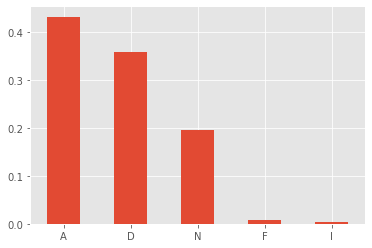

In [7]:
df_all.codigo_de_cierre.value_counts(normalize=True).plot.bar(rot=0)

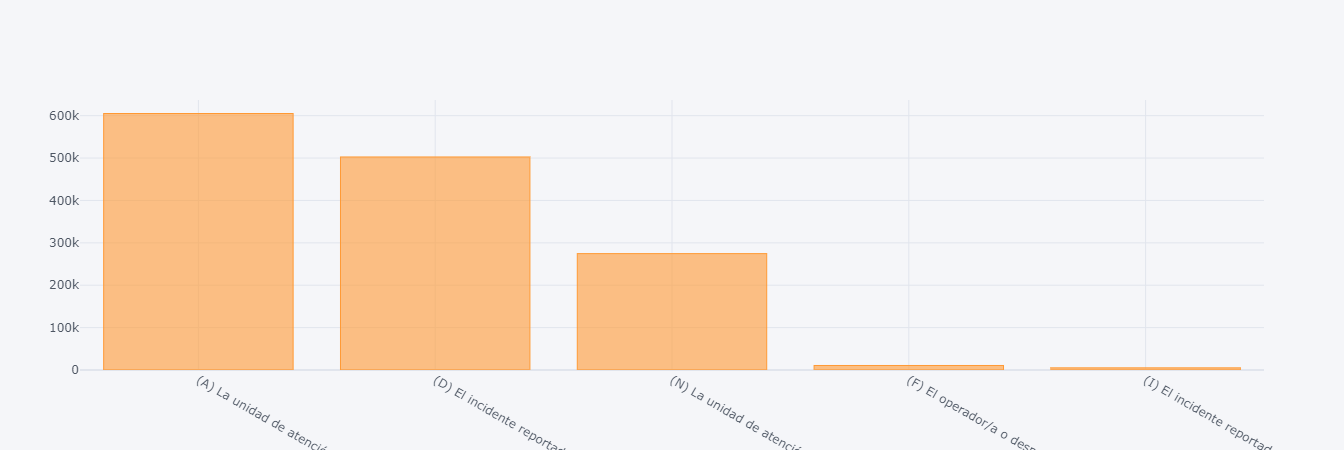

In [8]:
df_all.codigo_cierre.value_counts().iplot(kind='bar')

### Filtro de solo quedarnos con las llamadas Afirmativas (A, I)

In [9]:
df_A = df_all[df_all.codigo_de_cierre.isin(['A','I'])]

In [10]:
df_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610203 entries, 0 to 1397988
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   folio              610203 non-null  object        
 1   fecha_creacion     610203 non-null  datetime64[ns]
 2   hora_creacion      610203 non-null  object        
 3   dia_semana         610203 non-null  object        
 4   codigo_cierre      610203 non-null  object        
 5   fecha_cierre       610203 non-null  datetime64[ns]
 6   año_cierre         610203 non-null  int64         
 7   mes_cierre         610203 non-null  object        
 8   hora_cierre        610203 non-null  object        
 9   delegacion_inicio  610193 non-null  object        
 10  incidente_c4       610203 non-null  object        
 11  latitud            610072 non-null  float64       
 12  longitud           610074 non-null  float64       
 13  clas_con_f_alarma  610203 non-null  object 

In [11]:
print('Numero de llamadas recibidas: ',df_all.shape[0])
print('Numero de accidentes afirmados: ',df_A.shape[0])

Numero de llamadas recibidas:  1397992
Numero de accidentes afirmados:  610203


### Filtro de: **_requiere_ambulancia_**. 1 = Si requiere, 0 = No requiere.

Dividiremos los incidentes en dos grupos. El primero serán aquellos incidentes en los que SI se necesitará ambulancia (aquellos con lesionados confirmados o por confirmar) y el segundo grupo correspondera a los incidentes que NO requieran atención medica. A saber:

### Incidentes que requieren ambulancia
* accidente-choque con lesionado
* accidente-otros
* lesionado-accidente automovilístico
* lesionado-atropellado
* accidente-volcadura
* accidente-persona atrapada / desbarrancada
* cadáver-accidente automovilístico
* cadáver-atropellado
* accidente-motociclista
* accidente-choque con prensados
* accidente-vehiculo atrapado
* accidente-vehiculo desbarrancado
* accidente-ciclista
* accidente-monopatín
* sismo-choque con lesionados
* accidente-vehículo atrapado-varado
* accidente-ferroviario
* sismo-persona atropellada
* detención ciudadana-atropellado
* detención ciudadana-accidente automovilístico
* sismo-choque con prensados

### Incidentes que **NO** requieren ambulancia
* accidente-choque sin lesionado
* sismo-choque sin lesionados

In [12]:
sin_ambulancia = ['accidente-choque sin lesionados','sismo-choque sin lesionados']
df_A['requiere_ambulancia'] = np.where(df_A['incidente_c4'].isin(sin_ambulancia),0,1)

Text(0, 0.5, '%')

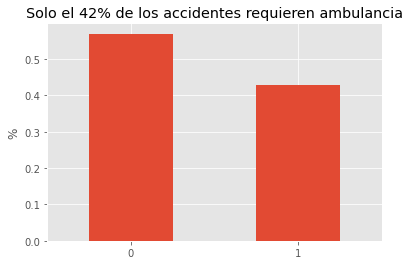

In [13]:
df_A.requiere_ambulancia.value_counts(normalize=True).plot.bar(rot=0, title="Solo el 42% de los accidentes requieren ambulancia")
plt.ylabel("%")

In [14]:
# Filtro por accidentes que necesitan ambulancias
df_A = df_A[df_A['requiere_ambulancia'] == 1]

### Del Reporte de AED observamos que hay muy pocos nulos, los quitaremos

In [15]:
nulos = df_A.isnull().sum()/df_A.shape[0]
nulos[nulos!=0]

delegacion_inicio    0.000023
latitud              0.000274
longitud             0.000271
geopoint             0.000278
dtype: float64

In [16]:
df_A.dropna(inplace=True)

Delegaciones correlacionadas

Veamos si si....

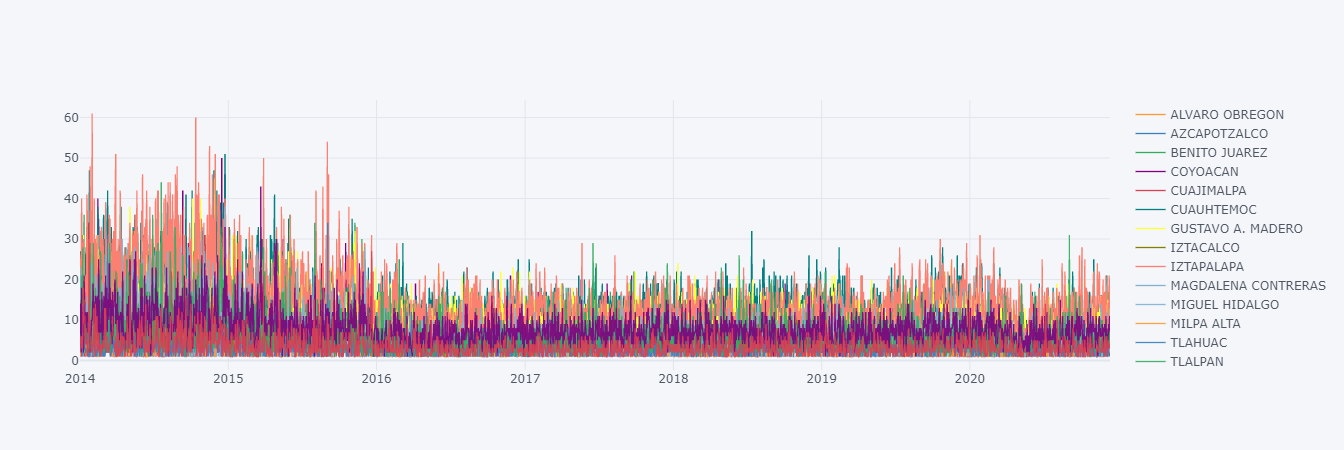

In [19]:
df_A.groupby(['fecha_cierre','delegacion_cierre']).size().unstack().iplot()

## Generacion de modelo de ML con variables temporales y dummies en fechas, delegacion, etc.

In [55]:
df_ml = df_A.groupby(['fecha_cierre','delegacion_cierre']).size().reset_index()
df_ml.columns = ['fecha_cierre','alcaldia', 'numero_accidentes']
df_ml.sort_values(['fecha_cierre','alcaldia'], inplace=True)

In [56]:
df_ml.numero_accidentes.shift()

0         NaN
1         8.0
2         4.0
3         6.0
4         5.0
         ... 
37148    15.0
37149     5.0
37150     4.0
37151     4.0
37152    10.0
Name: numero_accidentes, Length: 37153, dtype: float64

In [58]:
dict_temp = {}
for i in range(1,29):
    df_agg = df_ml.groupby('alcaldia').numero_accidentes.shift(i)
    df_temp = pd.DataFrame(df_agg).dropna()
    df_temp.columns = ['shift_'+str(i)]
    dict_temp['shift_'+str(i)] = df_temp

In [66]:
dict_temp['shift_']

shift_6
88         8.0
89         4.0
90         6.0
91         5.0
93        11.0
...        ...
37148      1.0
37149      1.0
37150      3.0
37151      3.0
37152      1.0

[37057 rows x 1 columns]

In [67]:
df_ml

fecha_cierre             alcaldia  numero_accidentes
0       2014-01-01       ALVARO OBREGON                  8
1       2014-01-01         AZCAPOTZALCO                  4
2       2014-01-01        BENITO JUAREZ                  6
3       2014-01-01             COYOACAN                  5
4       2014-01-01           CUAUHTEMOC                 11
...            ...                  ...                ...
37148   2020-12-11       MIGUEL HIDALGO                  5
37149   2020-12-11              TLAHUAC                  4
37150   2020-12-11              TLALPAN                  4
37151   2020-12-11  VENUSTIANO CARRANZA                 10
37152   2020-12-11           XOCHIMILCO                  4

[37153 rows x 3 columns]

In [85]:
dfs = [x for x in dict_temp.values()]
dfs.append(df_ml)

from functools import reduce 
# Merge de DataFrames

df_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True,
                                            how='left'), dfs)

In [86]:
df_merged.dropna(inplace=True)

In [93]:
df_merged

shift_1  shift_2  shift_3  shift_4  shift_5  shift_6  shift_7  shift_8  \
417        4.0     10.0     16.0      7.0      6.0      6.0      9.0     13.0   
418        4.0      1.0      5.0      4.0     17.0      3.0      3.0      7.0   
419       12.0     14.0     10.0     11.0     21.0      7.0     13.0      7.0   
420        4.0     11.0     26.0     11.0     12.0      8.0      2.0     15.0   
422       15.0     16.0     14.0     17.0     47.0     10.0     34.0     12.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
37148      2.0      5.0      3.0      5.0      7.0      1.0      3.0      5.0   
37149      6.0      5.0      1.0      2.0      4.0      1.0      3.0      5.0   
37150      3.0      6.0      8.0      8.0      5.0      3.0      7.0      6.0   
37151     11.0      7.0      9.0      8.0      7.0      3.0      5.0      8.0   
37152      3.0      4.0      3.0      5.0      3.0      1.0      2.0      6.0   

       shift_9  shift_10  ...  shift_22  shift_23  shift_24  shift_25  \
417        5.0       8.0  ...      21.0      10.0      12.0      16.0   
418        7.0       5.0  ...       2.0       5.0       1.0       6.0   
419        5.0       8.0  ...      10.0       6.0      11.0      21.0   
420        9.0      10.0  ...      10.0      21.0       6.0      11.0   
422       18.0      25.0  ...      13.0      20.0      25.0      22.0   
...        ...       ...  ...       ...       ...       ...       ...   
37148     12.0       2.0  ...      14.0       4.0      10.0       5.0   
37149      3.0       1.0  ...       1.0       1.0       3.0       7.0   
37150      5.0      10.0  ...       3.0       6.0       9.0       5.0   
37151      4.0      11.0  ...       6.0       6.0       8.0       6.0   
37152      4.0       6.0  ...       2.0       2.0       6.0       5.0   

       shift_26  shift_27  shift_28  fecha_cierre             alcaldia  \
417        22.0       7.0       8.0    2014-01-29       ALVARO OBREGON   
418         5.0       9.0       4.0    2014-01-29         AZCAPOTZALCO   
419        20.0      16.0       6.0    2014-01-29        BENITO JUAREZ   
420        13.0      12.0       5.0    2014-01-29             COYOACAN   
422        12.0      27.0      11.0    2014-01-29           CUAUHTEMOC   
...         ...       ...       ...           ...                  ...   
37148       6.0       4.0       8.0    2020-12-11       MIGUEL HIDALGO   
37149       1.0       6.0       1.0    2020-12-11              TLAHUAC   
37150      11.0       3.0       9.0    2020-12-11              TLALPAN   
37151      11.0      11.0      10.0    2020-12-11  VENUSTIANO CARRANZA   
37152       2.0       3.0       3.0    2020-12-11           XOCHIMILCO   

       numero_accidentes  
417                    3  
418                    1  
419                   19  
420                    5  
422                   19  
...                  ...  
37148                  5  
37149                  4  
37150                  4  
37151                 10  
37152                  4  

[36705 rows x 31 columns]

In [111]:
cols_temp = [col for col in df_merged.columns if 'shift' in col]
df_merged.groupby(['fecha_cierre','alcaldia'])[cols_temp_2[:3]].max(1).unstack()

shift_1                                                 \
alcaldia     ALVARO OBREGON AZCAPOTZALCO BENITO JUAREZ COYOACAN CUAJIMALPA   
fecha_cierre                                                                 
2014-01-29              4.0          4.0          12.0      4.0        NaN   
2014-01-30              3.0          1.0          19.0      5.0        NaN   
2014-01-31             14.0          3.0          22.0     13.0        NaN   
2014-02-01              5.0         15.0          24.0      8.0        NaN   
2014-02-02             13.0          2.0          23.0      9.0        NaN   
...                     ...          ...           ...      ...        ...   
2020-12-07              4.0          7.0           5.0      3.0        NaN   
2020-12-08              5.0          2.0           4.0      5.0        NaN   
2020-12-09              5.0          2.0           5.0      4.0        2.0   
2020-12-10              9.0          7.0           6.0      8.0        4.0   
2020-12-11              7.0          1.0           6.0      5.0        NaN   

                                                                \
alcaldia     CUAUHTEMOC GUSTAVO A. MADERO IZTACALCO IZTAPALAPA   
fecha_cierre                                                     
2014-01-29         15.0              18.0       2.0       37.0   
2014-01-30         19.0              24.0       7.0       16.0   
2014-01-31         20.0              20.0       9.0       32.0   
2014-02-01         19.0              38.0       8.0       61.0   
2014-02-02          8.0              16.0       4.0       20.0   
...                 ...               ...       ...        ...   
2020-12-07         17.0              14.0       5.0       11.0   
2020-12-08         10.0              15.0       3.0        8.0   
2020-12-09         10.0               7.0       5.0       14.0   
2020-12-10         16.0               8.0       7.0       21.0   
2020-12-11         16.0               7.0       3.0       13.0   

                                  ...           shift_3                       \
alcaldia     MAGDALENA CONTRERAS  ... GUSTAVO A. MADERO IZTACALCO IZTAPALAPA   
fecha_cierre                      ...                                          
2014-01-29                   NaN  ...              18.0       7.0       48.0   
2014-01-30                   NaN  ...              29.0       4.0       22.0   
2014-01-31                   NaN  ...              18.0       2.0       37.0   
2014-02-01                   NaN  ...              24.0       7.0       16.0   
2014-02-02                   NaN  ...              20.0       9.0       32.0   
...                          ...  ...               ...       ...        ...   
2020-12-07                   2.0  ...               8.0       6.0       14.0   
2020-12-08                   NaN  ...               1.0       1.0        1.0   
2020-12-09                   NaN  ...              14.0       5.0       11.0   
2020-12-10                   2.0  ...              15.0       3.0        8.0   
2020-12-11                   NaN  ...               7.0       5.0       14.0   

                                                                            \
alcaldia     MAGDALENA CONTRERAS MIGUEL HIDALGO MILPA ALTA TLAHUAC TLALPAN   
fecha_cierre                                                                 
2014-01-29                   NaN            4.0        NaN     NaN    29.0   
2014-01-30                   NaN           10.0        NaN     2.0    16.0   
2014-01-31                   NaN            8.0        NaN     NaN    14.0   
2014-02-01                   NaN           14.0        NaN     3.0     7.0   
2014-02-02                   NaN           24.0        NaN     8.0     4.0   
...                          ...            ...        ...     ...     ...   
2020-12-07                   1.0            3.0        NaN     4.0     7.0   
2020-12-08                   NaN            1.0        2.0     NaN     3.0   
2020-12-09             

In [94]:
df_max = pd.DataFrame()
df_min = pd.DataFrame()
df_mean = pd.DataFrame()
df_median = pd.DataFrame()
df_std = pd.DataFrame()
df_cociente = pd.DataFrame()

cols_temp = [col for col in df_merged.columns if 'shift' in col] # obtencion de columnas de lags sin diff y de la moneda que queremos
print(cols_temp)
for i in range(2, 29):
    lista_lags = list(range(1, i+1))
    cols_temp_2 =cols_temp[:i]

    df_max_temp = df_merged[cols_temp_2].max(1)
    df_max_temp.columns = ['shift_max_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
    df_max = pd.concat([df_max, df_max_temp], 1)
    df_max.rename(columns={0:'shift_max_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

    df_min_temp = df_merged[cols_temp_2].min(1)
    df_min_temp.columns = ['shift_min_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
    df_min = pd.concat([df_min, df_min_temp], 1)
    df_min.rename(columns={0:'shift_min_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

    df_mean_temp = df_merged[cols_temp_2].mean(1)
    df_mean_temp.columns = ['shift_mean_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
    df_mean = pd.concat([df_mean, df_mean_temp], 1)
    df_mean.rename(columns={0:'shift_mean_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

    df_median_temp = df_merged[cols_temp_2].median(1)
    df_median_temp.columns = ['shift_median_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
    df_median = pd.concat([df_median, df_median_temp], 1)
    df_median.rename(columns={0:'shift_median_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

    df_std_temp = df_merged[cols_temp_2].std(1)
    df_std_temp.columns = ['shift_std_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
    df_std = pd.concat([df_std, df_std_temp], 1)
    df_std.rename(columns={0:'shift_std_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

    df_cociente_temp = df_merged[cols_temp_2[0]] / df_merged[cols_temp_2[-1]]
    df_cociente_temp.columns = ['shift_cociente_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])]
    df_cociente = pd.concat([df_cociente, df_cociente_temp], 1)
    df_cociente.rename(columns={0:'shift_cociente_t'+str(lista_lags[0])+'_t'+str(lista_lags[-1])}, inplace=True)

['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11', 'shift_12', 'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18', 'shift_19', 'shift_20', 'shift_21', 'shift_22', 'shift_23', 'shift_24', 'shift_25', 'shift_26', 'shift_27', 'shift_28']


In [89]:
# for df in [df_merged,df_max,df_min,df_mean,df_median,df_std,df_cociente]:
#     df.index.names = ['date']
#     df.index = pd.to_datetime(df.index)

In [90]:
data_frames = [df_merged,df_max,df_min,df_mean,df_median,df_std,df_cociente]

df_merged_2 = reduce(lambda  left, right: pd.merge(left,right,left_index=True, right_index=True,how='left'), data_frames)

In [91]:
df_merged_2

shift_1  shift_2  shift_3  shift_4  shift_5  shift_6  shift_7  shift_8  \
417        4.0     10.0     16.0      7.0      6.0      6.0      9.0     13.0   
418        4.0      1.0      5.0      4.0     17.0      3.0      3.0      7.0   
419       12.0     14.0     10.0     11.0     21.0      7.0     13.0      7.0   
420        4.0     11.0     26.0     11.0     12.0      8.0      2.0     15.0   
422       15.0     16.0     14.0     17.0     47.0     10.0     34.0     12.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
37148      2.0      5.0      3.0      5.0      7.0      1.0      3.0      5.0   
37149      6.0      5.0      1.0      2.0      4.0      1.0      3.0      5.0   
37150      3.0      6.0      8.0      8.0      5.0      3.0      7.0      6.0   
37151     11.0      7.0      9.0      8.0      7.0      3.0      5.0      8.0   
37152      3.0      4.0      3.0      5.0      3.0      1.0      2.0      6.0   

       shift_9  shift_10  ...  shift_cociente_t1_t19  shift_cociente_t1_t20  \
417        5.0       8.0  ...               2.000000               0.363636   
418        7.0       5.0  ...               1.000000               0.500000   
419        5.0       8.0  ...               1.200000               1.333333   
420        9.0      10.0  ...               0.666667               0.444444   
422       18.0      25.0  ...               0.789474               0.833333   
...        ...       ...  ...                    ...                    ...   
37148     12.0       2.0  ...               0.333333               0.400000   
37149      3.0       1.0  ...               1.500000               2.000000   
37150      5.0      10.0  ...               0.300000               0.375000   
37151      4.0      11.0  ...               1.222222               1.571429   
37152      4.0       6.0  ...               0.500000               1.000000   

       shift_cociente_t1_t21  shift_cociente_t1_t22  shift_cociente_t1_t23  \
417                 0.800000               0.190476               0.400000   
418                 0.666667               2.000000               0.800000   
419                 1.333333               1.200000               2.000000   
420                 0.666667               0.400000               0.190476   
422                 0.483871               1.153846               0.750000   
...                      ...                    ...                    ...   
37148               0.200000               0.142857               0.500000   
37149               1.200000               6.000000               6.000000   
37150               0.300000               1.000000               0.500000   
37151               1.833333               1.833333               1.833333   
37152               0.600000               1.500000               1.500000   

       shift_cociente_t1_t24  shift_cociente_t1_t25  shift_cociente_t1_t26  \
417                 0.333333               0.250000               0.181818   
418                 4.000000               0.666667               0.800000   
419                 1.090909               0.571429               0.600000   
420                 0.666667               0.363636               0.307692   
422                 0.600000               0.681818               1.250000   
...                      ...                    ...                    ...   
37148               0.200000               0.400000               0.333333   
37149               2.000000               0.857143               6.000000   
37150               0.333333               0.600000               0.272727   
37151               1.375000               1.833333               1.000000   
37152               0.500000               0.600000               1.500000   

       shift_cociente_t1_t27  shift_cociente_t1_t28  
417                 0.571429               0.500000  
418                 0.444444               1.000000  
419                 0.750000               2.0000

### Variables de fecha

In [92]:
month_dummie = pd.get_dummies(df_merged_2.index.month)
month_dummie.set_index(df_merged_2.index,inplace=True)
month_dummie.columns = [str(c)+'_month_dummi' for c in month_dummie.columns]

dayofweekdummie = pd.get_dummies(df_merged_2.index.dayofweek)
dayofweekdummie.set_index(df_merged_2.index,inplace=True)
dayofweekdummie.columns = [str(c)+'_dayofweek_dummi' for c in dayofweekdummie.columns]

df_merged_3 = pd.concat([df_merged_2,month_dummie,dayofweekdummie],1)
df_merged_3.head()

AttributeError: 'Index' object has no attribute 'month'

## Prueba de modelo con GBR, RF y SVR

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [75]:
print('Partición de datos, 80% train, 20% test')
train = df_merged_3[:2000]
test = df_merged_3[2000:]
y_train, y_test = train['num_accidentes'], test['num_accidentes']

print('entrenamiento modelo')
x_cols = [col for col in df_merged_3.columns if 'num_accidentes' != col]

rf_2 = RandomForestRegressor()
rf_2.fit(train[x_cols], y_train)

gbr_2 = GradientBoostingRegressor()
gbr_2.fit(train[x_cols], y_train)

svr_2 = SVR()
svr_2.fit(train[x_cols], y_train)

Partición de datos, 80% train, 20% test
entrenamiento modelo


SVR()

In [76]:
models = [('rf',rf_2), ('gbr',gbr_2),('svr',svr_2)]

In [77]:
for name,model in models:
    print(name)
    test['y_pred_'+name] = model.predict(test[x_cols])
    evaluate_model(name)

rf
////////////////////////////////////////
modelo:  rf
////////////////////////////////////////
R^2 =  0.068
Error cuadrático medio (RMSE) =  4.890
Error absoluto medio (MAE) =  3.780
MAPE:  38.68874783239804
gbr
////////////////////////////////////////
modelo:  gbr
////////////////////////////////////////
R^2 =  0.075
Error cuadrático medio (RMSE) =  4.872
Error absoluto medio (MAE) =  3.772
MAPE:  37.56165509387252
svr
////////////////////////////////////////
modelo:  svr
////////////////////////////////////////
R^2 =  0.050
Error cuadrático medio (RMSE) =  4.937
Error absoluto medio (MAE) =  3.811
MAPE:  36.630169529422844


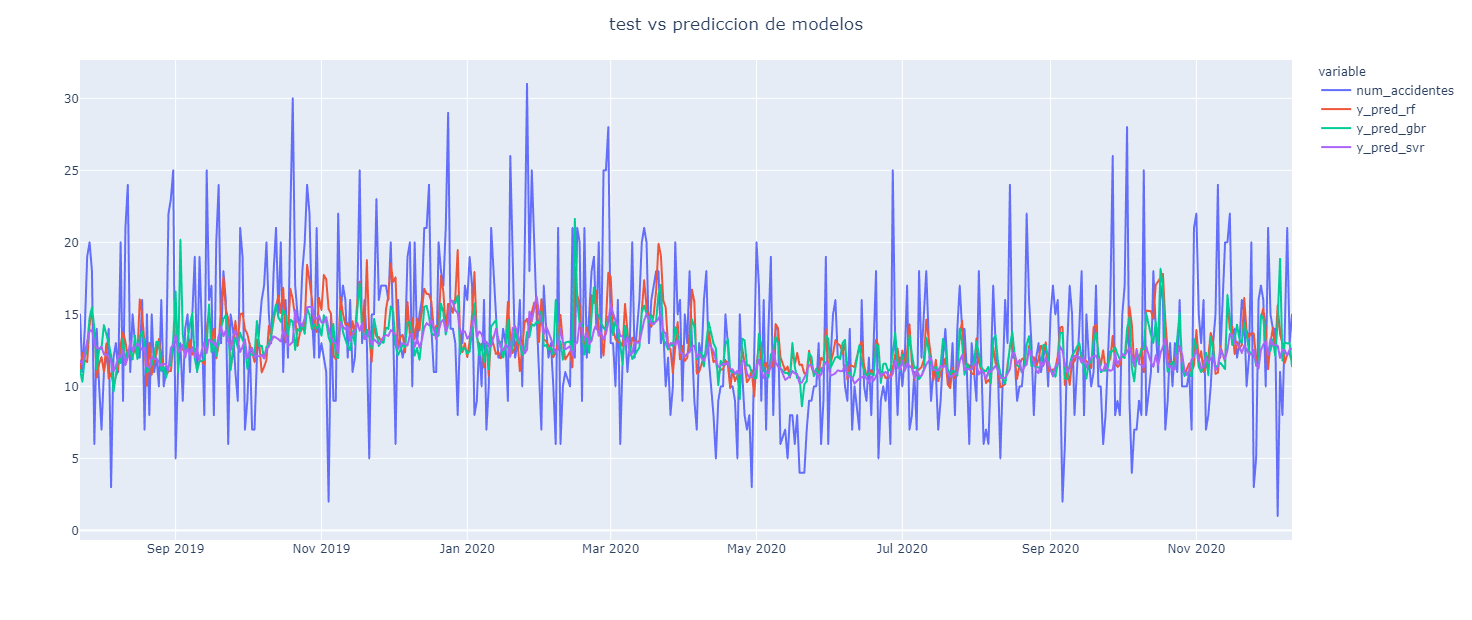

In [78]:
data_fig = test[x_cols]
fig_eval = px.line(test[['num_accidentes','y_pred_rf', 'y_pred_gbr', 'y_pred_svr']], x= test.index,
                   y=['num_accidentes','y_pred_rf', 'y_pred_gbr', 'y_pred_svr'])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

### Prueba con modelo con regresiones y KNN

In [79]:
numeric_cols = [col for col in x_cols if 'shift' in col]
categoric_cols = [col for col in x_cols if col not in numeric_cols]

train_std = (train[numeric_cols] - train[numeric_cols].mean()) / train[numeric_cols].std()
x_all = pd.concat([train_std,train[categoric_cols]],1)
x_all

shift_1   shift_2   shift_3   shift_4   shift_5   shift_6  \
date                                                                     
2014-01-29  2.868461  0.932861  4.264930 -0.357187  1.054070  0.155097   
2014-01-30  0.159932  2.867588  0.926634  4.264933 -0.358204  1.053841   
2014-01-31  2.223573  0.158970  2.852574  0.926735  4.263786 -0.358470   
2014-02-01  5.963922  2.222679  0.156258  2.852619  0.925682  4.263640   
2014-02-02  0.675842  5.963151  2.210594  0.156382  2.851511  0.925449   
...              ...       ...       ...       ...       ...       ...   
2019-07-18 -0.355978 -0.743903 -0.614118 -0.100403  0.155350  1.695801   
2019-07-19 -1.000866 -0.356957 -0.742514 -0.613972 -0.101427  0.155097   
2019-07-20 -0.098023 -1.001866 -0.357326 -0.742364 -0.614981 -0.101686   
2019-07-21  0.288910 -0.098994 -0.999306 -0.357187 -0.743370 -0.615254   
2019-07-22 -1.000866  0.287952 -0.100534 -0.999148 -0.358204 -0.743646   

             shift_7   shift_8   shift_9  shift_10  ...  10_month_dummi  \
date                                                ...                   
2014-01-29  1.949650  1.562889 -0.232142  2.710651  ...               0   
2014-01-30  0.153624  1.947553  1.562936 -0.232996  ...               0   
2014-01-31  1.051637  0.152455  1.947596  1.558789  ...               0   
2014-02-01 -0.359526  1.050004  0.152518  1.942743  ...               0   
2014-02-02  4.258825 -0.360430  1.050057  0.150958  ...               0   
...              ...       ...       ...       ...  ...             ...   
2019-07-18  0.153624 -0.360430  0.408957 -0.232996  ...               0   
2019-07-19  1.693075  0.152455 -0.360362  0.406927  ...               0   
2019-07-20  0.153624  1.691110  0.152518 -0.360981  ...               0   
2019-07-21 -0.102951  0.152455  1.691156  0.150958  ...               0   
2019-07-22 -0.616101 -0.103987  0.152518  1.686774  ...               0   

            11_month_dummi  12_month_dummi  0_dayofweek_dummi  \
date                                                            
2014-01-29               0               0                  0   
2014-01-30               0               0                  0   
2014-01-31               0               0                  0   
2014-02-01               0               0                  0   
2014-02-02               0               0                  0   
...                    ...             ...                ...   
2019-07-18               0               0                  0   
2019-07-19               0               0                  0   
2019-07-20               0               0                  0   
2019-07-21               0               0                  0   
2019-07-22               0               0                  1   

            1_dayofweek_dummi  2_dayofweek_dummi  3_dayofweek_dummi  \
date                                                                  
2014-01-29                  0                  1                  0   
2014-01-30                  0                  0                  1   
2014-01-31                  0                  0                  0   
2014-02-01                  0                  0                  0   
2014-02-02                  0                  0                  0   
...                       ...                ...                ...   
2019-07-18                  0                  0                  1   
2019-07-19                  0                  0                  0   
2019-07-20                  0                  0                  0   
2019-07-21                  0                  0                  0   
2019-07-22                  0                  0                  0   

            4_dayofweek_dummi  5_dayofweek_dummi  6_dayofweek_dummi  
date                                                                 
2014-01-29                  0                  0                  0  
2014-01-30                  0                  0                  0  
2014-01-31              

In [80]:
print('Partición de datos, 80% train, 20% test')
train = df_merged_3[:2000]
test = df_merged_3[2000:]
y_train, y_test = train['num_accidentes'], test['num_accidentes']

print('entrenamiento modelo')
x_cols = [col for col in df_merged_3.columns if 'num_accidentes' != col]

train_std = (train[numeric_cols] - train[numeric_cols].mean()) / train[numeric_cols].std()
train_std_all = pd.concat([train_std,train[categoric_cols]], 1)

train_norm_all = (train[x_cols] - train[x_cols].min())/ (train[x_cols].max() - train[x_cols].min())

test_std = (test[numeric_cols] - test[numeric_cols].mean()) / test[numeric_cols].std()
test_std_all = pd.concat([test_std, test[categoric_cols]], 1)

test_norm_all = (test[x_cols] - test[x_cols].min())/ (test[x_cols].max() - test[x_cols].min())

lr_2 = LinearRegression()
lr_2.fit(train_std_all, y_train)

ridge_2 = Ridge()
ridge_2.fit(train_std_all, y_train)

lasso_2 = Lasso()
lasso_2.fit(train_std_all, y_train)

knn_2 = KNeighborsRegressor()
knn_2.fit(train_norm_all, y_train)

Partición de datos, 80% train, 20% test
entrenamiento modelo


KNeighborsRegressor()

In [81]:
models = [('lr',lr_2), ('ridge',ridge_2),('lasso',lasso_2),('knn',knn_2)]

In [82]:
for name,model in models:
    print(name)
    if name == 'knn':
        data = test_norm_all
    else:
        data = test_std_all
    
    test['y_pred_'+name] = model.predict(data)
    evaluate_model(name)

lr
////////////////////////////////////////
modelo:  lr
////////////////////////////////////////
R^2 = -3949660749748833878016.000
Error cuadrático medio (RMSE) =  318389210071.581
Error absoluto medio (MAE) =  253057353435.699
MAPE:  2239652682404.998
ridge
////////////////////////////////////////
modelo:  ridge
////////////////////////////////////////
R^2 = -0.366
Error cuadrático medio (RMSE) =  5.920
Error absoluto medio (MAE) =  4.808
MAPE:  50.287298594776566
lasso
////////////////////////////////////////
modelo:  lasso
////////////////////////////////////////
R^2 = -0.165
Error cuadrático medio (RMSE) =  5.468
Error absoluto medio (MAE) =  4.359
MAPE:  46.753336403972476
knn
////////////////////////////////////////
modelo:  knn
////////////////////////////////////////
R^2 = -1.998
Error cuadrático medio (RMSE) =  8.771
Error absoluto medio (MAE) =  7.048
MAPE:  76.29557525666928


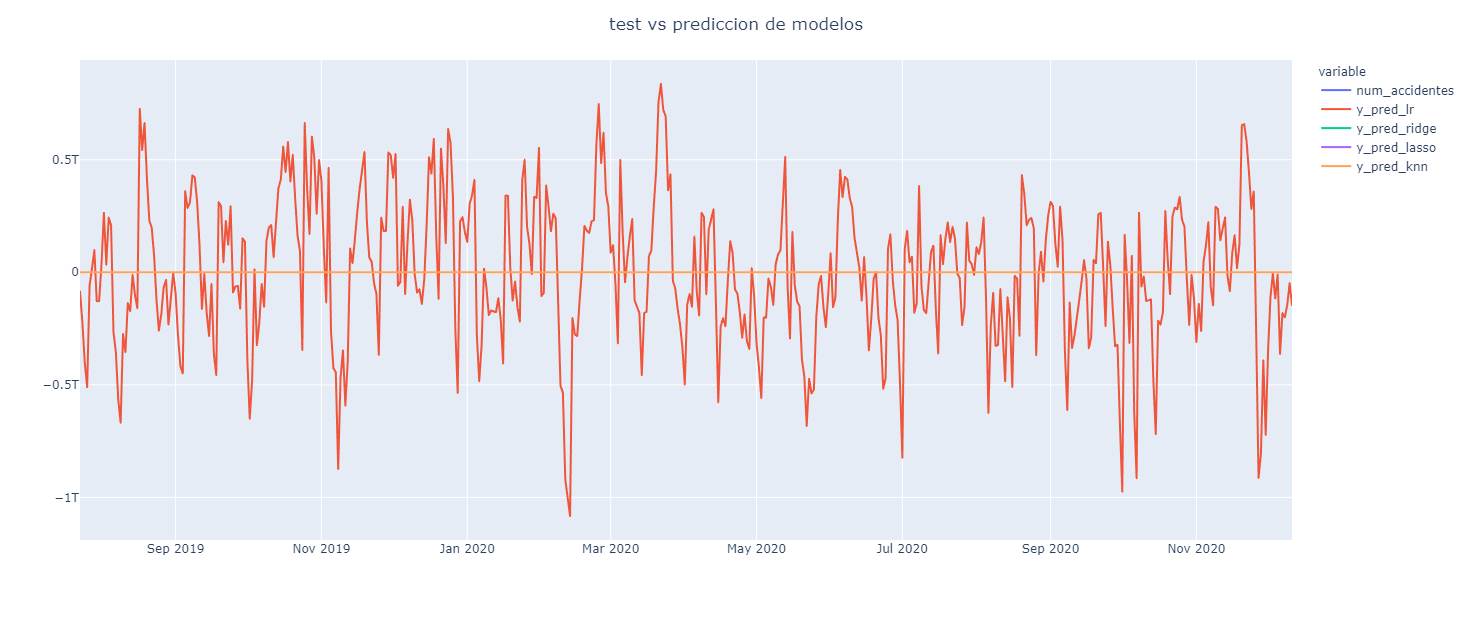

In [83]:
data_fig = test[x_cols]
fig_eval = px.line(test[['num_accidentes','y_pred_lr', 'y_pred_ridge', 'y_pred_lasso','y_pred_knn']], x= test.index,
                   y=['num_accidentes','y_pred_lr', 'y_pred_ridge', 'y_pred_lasso','y_pred_knn'])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

# Modelos de Serie de tiempo

Para la alcaldia iztapalapa

FALTA AGREGAR FUNDAMENTOS TEORICOS DE CADA MODELO

## Graficos de Autocorrelacion

In [84]:
from statsmodels.graphics.tsaplots import plot_acf

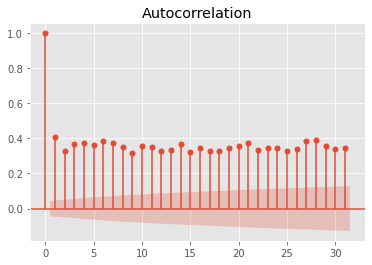

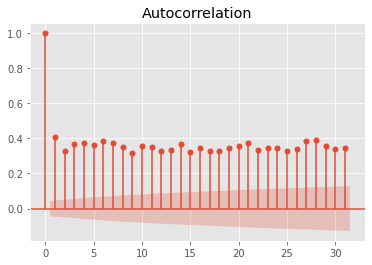

In [85]:
plot_acf(train.num_accidentes, lags=31)

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

<ipython-input-87-8bcd0fead952>:1: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



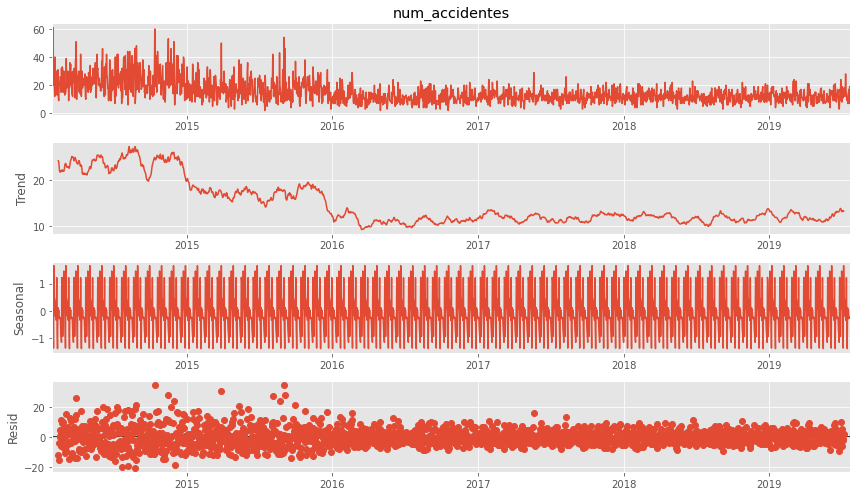

In [87]:
decomposition = seasonal_decompose(train.num_accidentes, freq=30, 
                                   model='additive')
plt.rcParams['figure.figsize'] = 12, 7
decomposition.plot()
plt.show();

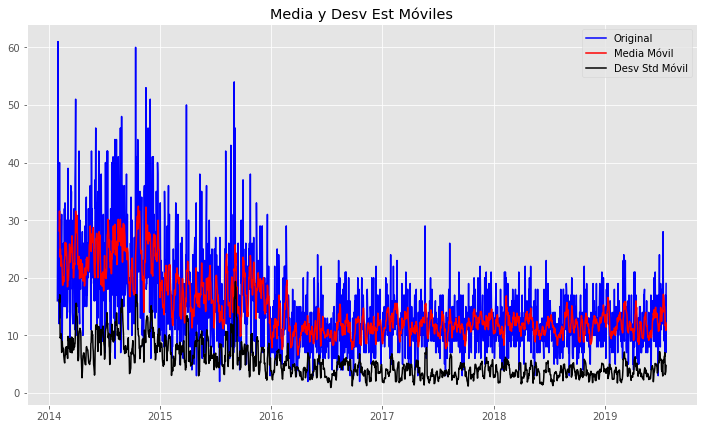

In [88]:
# Estadísticas móviles
rolmean = train.num_accidentes.rolling(window=7).mean()
rolstd = train.num_accidentes.rolling(window=7).std()

# Y sus gráficas
orig = plt.plot(train.num_accidentes, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Media Móvil')
std = plt.plot(rolstd, color='black', label = 'Desv Std Móvil')
plt.legend(loc='best')
plt.title('Media y Desv Est Móviles')
plt.show(block=False)

__Prueba de Dickey Fuller Aumentada o Prueba de Raíz Unitaria (Unit Root Test)__

Hipótesis nula (H0): la ST es no estacionaria.

Si el valor p (p-value) es menor que el umbral (el nivel de significancia de la prueba, generalmente 5% or 1%) se rechaza la hipótesis nula.

Si el valor p (p-value) es mayor que el umbral no podemos rechazar la hipótesis nula y se sospecha que la ST tiene un componente temporal.

In [89]:
from statsmodels.tsa.stattools import adfuller

print ('Resultados de la prueba Dickey-Fuller:')
dftest = adfuller( train.num_accidentes)

dfoutput = pd.Series(dftest[0:4], 
                     index=['Est. de Prueba',
                            'p-value',
                            '#Lags usados',
                            'No. de obs. usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor Crítico (%s)'%key] = value
print(dfoutput)

Resultados de la prueba Dickey-Fuller:
Est. de Prueba           -2.711474
p-value                   0.072074
#Lags usados             26.000000
No. de obs. usadas     1973.000000
Valor Crítico (1%)       -3.433669
Valor Crítico (5%)       -2.863006
Valor Crítico (10%)      -2.567550
dtype: float64


## Estationarización de la ST
__Se realiza por medio de diferencias (una versión discretizada de la derivada).__

- Primero se calcula la diferencia y(t) - y(t-1)
- Posteriormente se calcula la diferencia y(t) - y(t-12)
- Es de nuestro conocimiento que la ST tiene estacionalidad anual
- Se eliminan los datos faltantes

In [92]:
df_diff = (train.num_accidentes.diff()).diff(30)
df_diff.dropna(inplace=True)
print ('Resultados de la prueba Dickey-Fuller:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Est. de Prueba',
                            'p-value',
                            '#Lags usados',
                            'No. de obs. usadas'])
for key, value in dftest[4].items():
    dfoutput['Valor Crítico (%s)'%key] = value
print(dfoutput)

Resultados de la prueba Dickey-Fuller:
Est. de Prueba        -1.424895e+01
p-value                1.492589e-26
#Lags usados           2.600000e+01
No. de obs. usadas     1.942000e+03
Valor Crítico (1%)    -3.433722e+00
Valor Crítico (5%)    -2.863029e+00
Valor Crítico (10%)   -2.567563e+00
dtype: float64


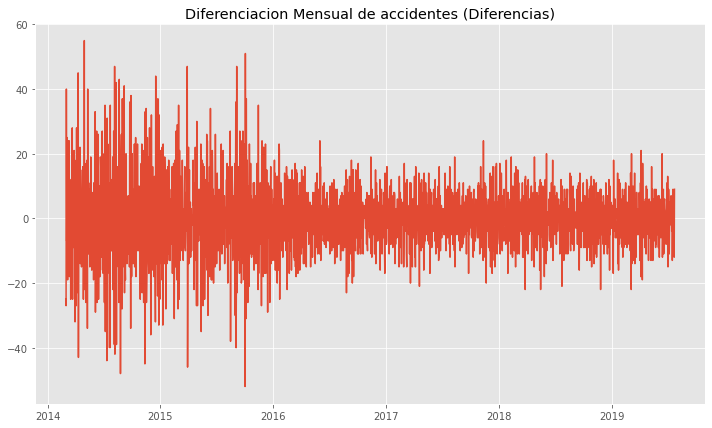

In [93]:
plt.plot(df_diff)
plt.title('Diferenciacion Mensual de accidentes (Diferencias)')
plt.savefig('diffplot')
plt.show()

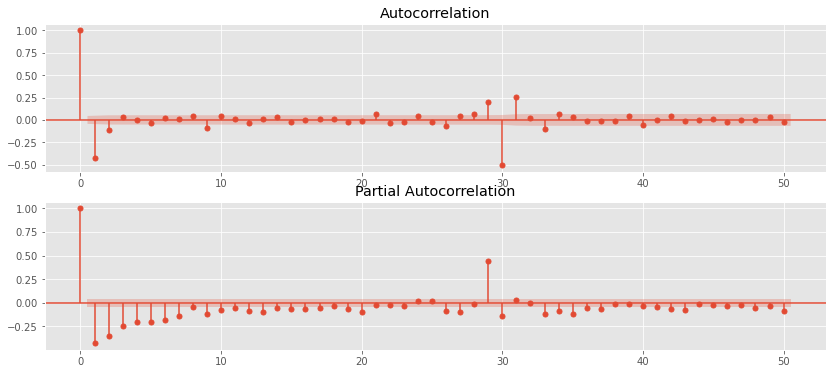

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diffAC, (dac, dpac) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), 
                                   sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=dac)
ax2 = plot_pacf(df_diff, lags=50, ax=dpac)
plt.savefig('acfpacf2')
plt.show()

# Model Parameter Estimation

In [ ]:
# import pmdarima as pm

# model = pm.auto_arima(train.num_accidentes, d=1, D=1,
#                       seasonal=True, m=30, trend='c', 
#                       start_p=0, start_q=0, max_order=6, 
#                       test='adf', stepwise=True, trace=True)

In [ ]:
# model.summary()

## Auto regresivos (AR)

In [95]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [96]:
# autoregresivo
autoreg_model = AutoReg(train.num_accidentes, lags=7)
autoreg_model_fit = autoreg_model.fit()

# MA
ma_model = ARIMA(train.num_accidentes, order=(0, 0, 7))
ma_model_fit = ma_model.fit()

# arma
arma_model = ARIMA(train.num_accidentes, order=(2, 0, 7))
arma_model_fit = arma_model.fit()

# arima
arima_model = ARIMA(train.num_accidentes, order=(1, 1, 7))
arima_model_fit = arima_model.fit()



C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\serch\a

In [97]:
# sarimax
sarimax_model = SARIMAX(train.num_accidentes, order=(1, 2, 7), seasonal_order=(0, 0, 0, 0))
sarimax_model_fit = sarimax_model.fit(disp=False)

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [98]:
autoreg_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:         num_accidentes   No. Observations:                 2000
Model:                     AutoReg(7)   Log Likelihood               -6516.251
Method:               Conditional MLE   S.D. of innovations              6.364
Date:                Thu, 25 Feb 2021   AIC                              3.710
Time:                        14:03:01   BIC                              3.736
Sample:                             7   HQIC                             3.720
                                 2000                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             2.8346      0.426      6.658      0.000       2.000       3.669
num_accidentes.L1     0.1740      0.022      7.832      0.000       0.130       0.217
num_accidentes.L2     0.0379      0.022      1.696      0.090      -0.006       0.082
num_accidentes.L3     0.1150      0.022      5.170      0.000       0.071       0.159
num_accidentes.L4     0.1254      0.022      5.641      0.000       0.082       0.169
num_accidentes.L5     0.1004      0.022      4.554      0.000       0.057       0.144
num_accidentes.L6     0.1330      0.022      6.008      0.000       0.090       0.176
num_accidentes.L7     0.1201      0.022      5.462      0.000       0.077       0.163
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0537           -0.0000j            1.0537           -0.0000
AR.2            0.7081           -1.1124j            1.3187           -0.1598
AR.3            0.7081           +1.1124j            1.3187            0.1598
AR.4           -0.3833           -1.3340j            1.3880           -0.2945
AR.5           -0.3833           +1.3340j            1.3880            0.2945
AR.6           -1.4053           -0.6194j            1.5358           -0.4339
AR.7           -1.4053           +0.6194j            1.5358            0.4339
-----------------------------------------------------------------------------
"""

In [99]:
models = [('autoreg',autoreg_model_fit), ('ma',ma_model_fit),('arma', arma_model_fit),('arima',arima_model_fit),("sarimax",sarimax_model_fit)]

for name,model in models:
    preds_temp = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    preds_temp.index = test.index
    test['y_pred_'+name] = preds_temp
    evaluate_model(name)

////////////////////////////////////////
modelo:  autoreg
////////////////////////////////////////
R^2 = -0.057
Error cuadrático medio (RMSE) =  5.209
Error absoluto medio (MAE) =  4.219
MAPE:  46.80106894464739
////////////////////////////////////////
modelo:  ma
////////////////////////////////////////
R^2 = -0.077
Error cuadrático medio (RMSE) =  5.259
Error absoluto medio (MAE) =  4.267
MAPE:  47.832834058136875
////////////////////////////////////////
modelo:  arma
////////////////////////////////////////
R^2 = -0.030
Error cuadrático medio (RMSE) =  5.143
Error absoluto medio (MAE) =  4.092
MAPE:  43.25387805662215
////////////////////////////////////////
modelo:  arima
////////////////////////////////////////
R^2 = -0.006
Error cuadrático medio (RMSE) =  5.081
Error absoluto medio (MAE) =  3.962
MAPE:  39.875297458389255
////////////////////////////////////////
modelo:  sarimax
////////////////////////////////////////
R^2 = -0.122
Error cuadrático medio (RMSE) =  5.366
Error abs

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\serch\anaconda3\envs\dsciencias_2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Us

### Resulta que le cuesta predecir conforme avanza el tiempo
Se adapta el codigo para que tome ventanas de tiempo en test

In [100]:
def walk_forward_prediction(name_model, model_fit, window):
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history.iloc[i] for i in range(len(history))]
    predictions = list()
    coef = model_fit.params
    for t in range(len(test)):
        length = len(history)
        lag = [history[i].num_accidentes for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test.iloc[t]
        predictions.append(yhat)
        history.append(obs)
    
    test['y_pred_'+name_model+'_wf'] = predictions

In [101]:
def evaluate_model_wf(name):
    print('//'*20)
    print('modelo: ',name)
    print('//'*20)
    
    r2 = r2_score(test['num_accidentes'], test['y_pred_'+name+'_wf'])
    rmse = mean_squared_error(test['num_accidentes'], test['y_pred_'+name+'_wf'], squared=False)
    mae = mean_absolute_error(test['num_accidentes'], test['y_pred_'+name+'_wf'])
    test = test[test.num_accidentes !=0]
    mape = (np.mean(np.abs(test['num_accidentes'] - test['y_pred_'+name+'_wf'])/np.abs(test['num_accidentes']))*100)
    
    print('R^2 = % 1.3f' %r2)
    print('Error cuadrático medio (RMSE) = % 1.3f' %rmse)
    print('Error absoluto medio (MAE) = % 1.3f' %mae)
    print('MAPE: ',mape)
    
    return r2,rmse,mae,mape
    
    
    

In [102]:
models = [('autoreg',autoreg_model_fit), ('ma',ma_model_fit),('arma', arma_model_fit),('arima',arima_model_fit),("sarimax",sarimax_model_fit)]

for name,model in models:
    print(name)
    walk_forward_prediction(name, model, 7)
    
    evaluate_model_wf(name)
    

autoreg
////////////////////////////////////////
modelo:  autoreg
////////////////////////////////////////


UnboundLocalError: local variable 'test' referenced before assignment

In [ ]:
data_fig = test[x_cols]
fig_eval = px.line(test[['num_accidentes','y_pred_autoreg_wf', 'y_pred_ma_wf', 'y_pred_arma_wf',
       'y_pred_arima_wf', 'y_pred_sarimax_wf']], x= test.index,
                   y=['num_accidentes','y_pred_autoreg_wf', 'y_pred_ma_wf', 'y_pred_arma_wf',
       'y_pred_arima_wf', 'y_pred_sarimax_wf'])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

### Optimizacion a ojimetro de modelos

In [ ]:
# autoregresivo
autoreg_model = AutoReg(train.num_accidentes, lags=7, trend='t',old_names =True)
autoreg_model_fit = autoreg_model.fit()

In [ ]:
models = [('autoreg',autoreg_model_fit), ('ma',ma_model_fit),('arma', arma_model_fit),('arima',arima_model_fit),("sarimax",sarimax_model_fit)]

for name,model in models:
    print(name)
    walk_forward_prediction(name, model, 7)
    evaluate_model_wf(name)

In [ ]:
data_fig = test[x_cols]
fig_eval = px.line(test[['num_accidentes','y_pred_autoreg_wf', 'y_pred_ma_wf', 'y_pred_arma_wf',
       'y_pred_arima_wf', 'y_pred_sarimax_wf']], x= test.index,
                   y=['num_accidentes','y_pred_autoreg_wf', 'y_pred_ma_wf', 'y_pred_arma_wf',
       'y_pred_arima_wf', 'y_pred_sarimax_wf'])

fig_eval.update_layout(title='test vs prediccion de modelos', title_x=0.5, xaxis_title='',
                   yaxis_title='', width=1200, height=620)
fig_eval.show()

In [ ]:
test.plot(x='num_accidentes',y='y_pred_autoreg_wf', kind='scatter')

# Modelo de todas las alcaldias y obtener que mejor modelo se ajusta a cada alcaldia

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
def walk_forward_prediction(name_model, model_fit, window):
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history.iloc[i] for i in range(len(history))]
    predictions = list()
    coef = model_fit.params
    for t in range(len(test)):
        length = len(history)
        lag = [history[i].num_accidentes for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test.iloc[t]
        predictions.append(yhat)
        history.append(obs)
    
    test['y_pred_'+name_model+'_wf'] = predictions

In [ ]:
def evaluate_model_wf(name):
    print('//'*20)
    print('modelo: ',name)
    print('//'*20)
    
    r2 = r2_score(test['num_accidentes'], test['y_pred_'+name+'_wf'])
    rmse = mean_squared_error(test['num_accidentes'], test['y_pred_'+name+'_wf'], squared=False)
    mae = mean_absolute_error(test['num_accidentes'], test['y_pred_'+name+'_wf'])
    temp_test = test[test.num_accidentes !=0]
    mape = (np.mean(np.abs(temp_test['num_accidentes'] - temp_test['y_pred_'+name+'_wf'])/np.abs(temp_test['num_accidentes']))*100)
    
    print('R^2 = % 1.3f' %r2)
    print('Error cuadrático medio (RMSE) = % 1.3f' %rmse)
    print('Error absoluto medio (MAE) = % 1.3f' %mae)
    print('MAPE: ',mape)
    
    return r2,rmse,mae,mape
    
    
    

In [ ]:
# plt.figure(figsize=(20,5))
autoreg_model_fit.plot_predict(start=len(train), end=len(train)+len(test)-1,figsize=(20,5))
plt.xlim()

In [ ]:
for alc in df_A.delegacion_cierre.unique():
    print('//'*90)
    print(alc)
    df_alcaldia =  df_A[df_A.delegacion_cierre == alc]
    df_alc = df_alcaldia.groupby('fecha_cierre').size()
    df_alc = pd.DataFrame(df_alc)
    df_alc.columns = ['num_accidentes']
    
    df_alc = df_alc.asfreq('d')
    df_alc.fillna(0,inplace=True)
        
    print('Partición de datos, 90% train, 10% test')
    num_train = int(len(df_alc) * 0.90)
    train = df_alc[:num_train]
    test = df_alc[num_train:]
    y_train, y_test = train['num_accidentes'], test['num_accidentes']
    
    print('Veamos la autocorrelacion y autocorrelacion parcial')
    plot_acf(train.num_accidentes, lags=31) # las pone al final >s
    plt.show()
    plot_pacf(train.num_accidentes, lags=31)
    plt.show()
    
    # autoregresivo
    autoreg_model = AutoReg(train.num_accidentes, lags=7,old_names=False)
    autoreg_model_fit = autoreg_model.fit()

    # MA
    ma_model = ARIMA(train.num_accidentes, order=(0, 0, 7))
    ma_model_fit = ma_model.fit()

    # arma
    arma_model = ARIMA(train.num_accidentes, order=(2, 0, 7))
    arma_model_fit = arma_model.fit()

    # arima
    arima_model = ARIMA(train.num_accidentes, order=(1, 1, 7))
    arima_model_fit = arima_model.fit()
    
    # sarimax
    sarimax_model = SARIMAX(train.num_accidentes, order=(1,1,7), seasonal_order=(0, 0, 0, 0))
    sarimax_model_fit = sarimax_model.fit(disp=False)
    
    models = [('autoreg',autoreg_model_fit), ('ma',ma_model_fit),('arma', arma_model_fit),('arima',arima_model_fit),("sarimax",sarimax_model_fit)]

    for name,model in models:
        walk_forward_prediction(name, model, 7)
        evaluate_model_wf(name)
        
        
    fig_eval = px.line(test[['num_accidentes','y_pred_autoreg_wf', 'y_pred_ma_wf', 'y_pred_arma_wf',
           'y_pred_arima_wf', 'y_pred_sarimax_wf']], x= test.index,
                       y=['num_accidentes','y_pred_autoreg_wf', 'y_pred_ma_wf', 'y_pred_arma_wf',
           'y_pred_arima_wf', 'y_pred_sarimax_wf'])

    fig_eval.update_layout(title='test vs prediccion de modelos en '+alc, title_x=0.5, xaxis_title='',
                       yaxis_title='', width=1200, height=620)
    fig_eval.show()
        
    print('//'*90)

In [ ]:
len(test)

# Modelo por clusters

In [ ]:
temp = df_A.groupby(['delegacion_cierre','fecha_cierre']).size().reset_index()
temp.columns = ['delegacion_cierre','fecha_cierre','num_accidentes']
temp

In [ ]:
df_cluster_alcaldias = pd.DataFrame(df_temp['cluster']).reset_index()
df_cluster_alcaldias

In [ ]:
temp.merge(df_cluster_alcaldias, on='delegacion_cierre')

In [ ]:
print('Partición de datos, 80% train, 20% test')
train = df_merged[:2000]
test = df_merged[2000:]
y_train, y_test = train['num_accidentes'], test['num_accidentes']

print('entrenamiento modelo')
x_cols = [col for col in df_merged.columns if 'num_accidentes' != col]